# Load the data
* zarr_loc: processed zarr file from nd2 
* xlm_lox: plate layout (Elements)
* nd2_loc: nd2 file (Elements)

In [119]:
import csv
from wellplate.elements import well_ind_to_id


display(meta_data)

,well,AB,Primary
0,A1,A,D
1,A2,A,D
2,A3,A,D
3,A4,A,D
4,A5,A,D
...,...,...,...
91,H8,A,D
92,H9,A,D
93,H10,A,D
94,H11,A,D


In [128]:
%load_ext autoreload
%autoreload 2

import zarr
from wellplate.elements import read_plate_xml, read_nd2, read_plate_csv
zarr_loc = 'C:/example_data/reprocessed2.zarr'
xml_loc = 'C:/example_data/HEK002-Label_ab-epitope-scaffold-fluorophore-2.xml'
csv_loc = 'C:/example_data/96w Sandbox - HEK002_MAPS.csv'
nd2_loc = 'C:/example_data/220714_96w-Merged_DAPI-GFP-555-647.nd2'

#meta_data, _, _ = read_plate_xml(xml_loc)
meta_data = read_plate_csv(csv_loc)
proc_data = zarr.open(zarr_loc)
im_data, channel_names, colormaps = read_nd2(nd2_loc)
print(channel_names)
display(meta_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['Bright Field', '365 nm', '488 nm', '561 nm', '640 nm']


,well,SCAFFOLD,EPITOPE,PRIMARY-01,SECONDARY-01,PRIMARY-SECONDARY-02,NOTES
0,A1,eGFP-ct1,ALFA,Rb-ALFA-01,Rb-AL647,"Ch-GFP, Gt-AL647",A1
1,A2,eGFP-ct1,ALFA,Rb-ALFA-01,Rb-AL647,"Ch-GFP, Gt-AL647",A2
2,A3,eGFP-ct1,ALFA,Rb-ALFA-01,Rb-AL647,"Ch-GFP, Gt-AL647",A3
3,A4,eGFP-ct1,ALFA,Rb-ALFA-02-647,Rb-AL647,"Ch-GFP, Gt-AL647",A4
4,A5,eGFP-ct1,ALFA,Rb-ALFA-02-647,Rb-AL647,"Ch-GFP, Gt-AL647",A5
...,...,...,...,...,...,...,...
91,H8,eGFP-ct3,VSV,Gt-VSV-03,none,none,No Goat 2ndary at the time of experiment
92,H9,eGFP-ct3,VSV,Gt-VSV-03,none,none,No Goat 2ndary at the time of experiment
93,H10,none,none,none,none,none,H10
94,H11,none,none,none,none,none,H11


# Browse plate map

In [129]:
from wellplate.plots import napari_plate_view
viewer = napari_plate_view(nd2_loc)

In [135]:
import panel as pn
from wellplate.plots import plate_map

plate_map(meta_data,viewer)

Column
    [0] Column(margin=5, name='PlateMap', width=300)
        [0] StaticText(value='<b>PlateMap</b>')
        [1] Select(name='Condition', options=OrderedDict([('SCAFFOLD', ...]), value='SCAFFOLD')
    [1] ParamMethod(method)

# Create comparison groups

In [23]:
groups = []
epitopes = ['ALFA','HA','GLU2','OLLAS','PRTC1','VSV']
scaffold = ['eGFP-ct1','eGFP-ct1'
# epitope groups.
for epitope in epitopes:
    groups.append({'name':epitope, 'indices':meta_data.loc[(meta_data['Epitope']==epitope)].index.values})
# Negative control
groups.append({'name':'-epi/-label', 'indices': meta_data.loc[(meta_data['Epitope']=='None') & (meta_data['Fluorophore']=='None')].index.values})
groups.append({'name':'-epi/+label', 'indices': meta_data.loc[(meta_data['Scaffold']=='none') & (meta_data['Fluorophore']=='AL64')].index.values})
display(groups)

[{'name': 'ALFA',
  'indices': array([ 0,  1,  2,  3,  4,  5, 12, 13, 14, 15, 16, 17], dtype=int64)},
 {'name': 'HA',
  'indices': array([ 6,  7,  8,  9, 10, 11, 18, 19, 20, 21, 22, 23], dtype=int64)},
 {'name': 'GLU2',
  'indices': array([24, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 41], dtype=int64)},
 {'name': 'OLLA',
  'indices': array([30, 31, 32, 33, 34, 35, 42, 43, 44, 45, 46, 47, 57, 58, 59, 69, 70,
         71], dtype=int64)},
 {'name': 'PRTC',
  'indices': array([48, 49, 50, 51, 52, 53, 54, 55, 56, 60, 61, 62, 63, 64, 65, 66, 67,
         68], dtype=int64)},
 {'name': 'VSV',
  'indices': array([72, 73, 74, 75, 76, 77, 78, 79, 80, 84, 85, 86, 87, 88, 89, 90, 91,
         92], dtype=int64)},
 {'name': '-epi/-label', 'indices': array([93, 94, 95], dtype=int64)},
 {'name': '-epi/+label', 'indices': array([81, 82, 83], dtype=int64)}]

In [46]:
import numpy as np
import pandas as pd
# Parameters.
dapi_channel = '365 nm'
scaffold_channel = '488 nm'
epi_channel = '640 nm'
threshold_factor = 0.5

signal_data = []
for group in groups:
    print(group['name'])
    ratio_scores = []
    for ind in group['indices']:
        # get masks.
        masks = proc_data[f'cells/masks/{ind}/{dapi_channel}'][:]
        num_masks = masks.max()
        # get image.
        im = im_data[ind,channel_names.index(scaffold_channel),:,:].to_numpy()
        # get intensities
        intensities = []
        for i_mask in range(num_masks):
            cell_mask = masks==i_mask
            intensities.append(im[cell_mask].mean())
        intensities = np.array(intensities)
        #get background pixels.
        bg_pixs = im[masks==0]
        # THRESHOLD.
        threshold = bg_pixs.mean()+(threshold_factor*bg_pixs.std())
        sig_cells = np.argwhere(intensities>threshold)
        # get epi intensities.
        im = im_data[ind,channel_names.index(epi_channel),:,:].to_numpy()
        epi_intensities = []
        for i_mask in sig_cells:
            cell_mask = masks==i_mask
            epi_intensities.append(im[cell_mask].mean())    
        epi_intensities = np.array(epi_intensities)
        # store info
        signal_data.append({'group':group['name'],'well':ind,'num_cells': num_masks,
                            'num_sig_cells':sig_cells.size,'scaffold_signal':intensities[sig_cells].mean(),'epi_signal':epi_intensities.mean()})
signal_data = pd.DataFrame(signal_data)
display(signal_data)

ALFA
HA
GLU2
OLLA
PRTC
VSV


C:\Users\Johan\AppData\Local\Temp\ipykernel_16968\3263942689.py:39: RuntimeWarning: Mean of empty slice.
  'num_sig_cells':sig_cells.size,'scaffold_signal':intensities[sig_cells].mean(),'epi_signal':epi_intensities.mean()})
C:\Users\Johan\anaconda3\envs\wellplate\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-epi/-label
-epi/+label


,group,well,num_cells,num_sig_cells,scaffold_signal,epi_signal
0,ALFA,0,614,322,367.910740,3721.741424
1,ALFA,1,1987,601,341.122865,3665.981338
2,ALFA,2,1989,575,529.453046,4651.289284
3,ALFA,3,1878,582,300.859010,814.446903
4,ALFA,4,1214,454,433.317844,1211.640199
...,...,...,...,...,...,...
91,-epi/-label,94,2951,66,538.736965,10310.931149
92,-epi/-label,95,2732,22,788.258700,14590.254224
93,-epi/+label,81,3038,557,126.333351,145.523576
94,-epi/+label,82,1995,440,125.034945,140.580188


In [69]:
signal_data['ratio'] =  signal_data['epi_signal']/signal_data['scaffold_signal']
signal_data['perc_pos'] =  (signal_data['num_sig_cells']/signal_data['num_cells'])*100
display(signal_data.loc[signal_data['group']=='ALFA'])
display(signal_data.groupby('group').mean())
display(signal_data.groupby('group').std())

,group,well,num_cells,num_sig_cells,scaffold_signal,epi_signal,ratio,perc_pos
0,ALFA,0,614,322,367.910740,3721.741424,10.115881,52.442997
1,ALFA,1,1987,601,341.122865,3665.981338,10.746806,30.246603
2,ALFA,2,1989,575,529.453046,4651.289284,8.785084,28.908999
3,ALFA,3,1878,582,300.859010,814.446903,2.707072,30.990415
4,ALFA,4,1214,454,433.317844,1211.640199,2.796193,37.397035
5,ALFA,5,1841,587,427.231568,1373.683770,3.215314,31.884845
6,ALFA,12,548,119,1477.579717,1196.208388,0.809573,21.715328
7,ALFA,13,965,420,1383.064287,1641.190423,1.186634,43.523316
8,ALFA,14,946,69,1550.377080,5134.991407,3.312092,7.293869
9,ALFA,15,2174,544,1151.642774,1386.225579,1.203694,25.022999


,well,num_cells,num_sig_cells,scaffold_signal,epi_signal,ratio,perc_pos
group,,,,,,,
-epi/+label,82.0,2054.333333,456.000000,127.468734,141.916998,1.113977,24.407142
-epi/-label,94.0,2695.333333,58.666667,604.773990,11937.506978,20.012920,2.234630
ALFA,8.5,1379.000000,378.666667,870.222080,2456.481091,4.054627,27.674836
GLU2,32.5,852.666667,253.750000,809.188213,3737.017024,4.377429,32.144106
HA,14.5,1336.000000,709.333333,4605.839533,3636.271269,2.436411,44.806083
OLLA,47.0,1003.388889,328.055556,1929.788468,4230.787770,3.155640,35.977818
PRTC,58.0,726.055556,347.055556,2108.296866,4795.101032,4.840165,42.531716
VSV,82.0,795.333333,259.388889,2277.707116,5957.411015,4.119536,35.152909


,well,num_cells,num_sig_cells,scaffold_signal,epi_signal,ratio,perc_pos
group,,,,,,,
-epi/+label,1.000000,955.382820,94.026592,3.158434,3.158031,0.044023,7.529462
-epi/-label,1.000000,275.833887,33.605555,160.968144,2316.877711,2.082717,1.428410
ALFA,6.515715,569.308672,211.586360,505.152844,1488.873707,3.632551,13.449198
GLU2,6.515715,405.938942,182.983916,185.892019,3415.648864,3.505766,19.282450
HA,6.515715,769.507989,665.049599,3664.394346,3544.136708,3.921935,31.720362
OLLA,13.907256,621.217887,392.331713,1297.759463,3400.557411,3.964341,29.318472
PRTC,6.721344,307.566439,266.335806,1644.202993,4758.509208,6.037451,24.244582
VSV,6.721344,333.002031,182.275209,1908.305273,6181.153105,6.024958,23.348335


# get intensities of positive cells.


In [48]:

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
well=94
dapi_channel = '365 nm'
positive_channel = '488 nm'
threshold_factor = 0.5
# get masks.
masks = proc_data[f'cells/masks/{well}/{dapi_channel}'][:]
num_masks = masks.max()
# get image.
im = im_data[well,channel_names.index(positive_channel),:,:].to_numpy()
# get intensities
intensities = []
for i_mask in range(num_masks):
    cell_mask = masks==i_mask
    intensities.append(im[cell_mask].mean())
#get background pixels.
bg_pixs = im[masks==0]
# THRESHOLD.
threshold = bg_pixs.mean()+(threshold_factor*bg_pixs.std())
sig_cells = np.argwhere(intensities>threshold)
print(f'number of cell:{len(intensities)}, signficant signal: {((sig_cells.size/len(intensities))*100):.2f}%')
sig_masks = masks.copy()
sig_masks[np.isin(sig_masks,sig_cells)==False] = 0

number of cell:2951, signficant signal: 2.24%


(array([0.00000000e+00, 9.67446592e-03, 1.35639200e-04, 7.46015599e-05,
        5.42556799e-05, 2.03458800e-05, 1.69549000e-05, 6.78195999e-06,
        3.39097999e-06, 3.39097999e-06, 3.39097999e-06, 0.00000000e+00,
        0.00000000e+00, 3.39097999e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.39097999e-06, 0.00000000e+00]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
 <BarContainer object of 19 artists>)

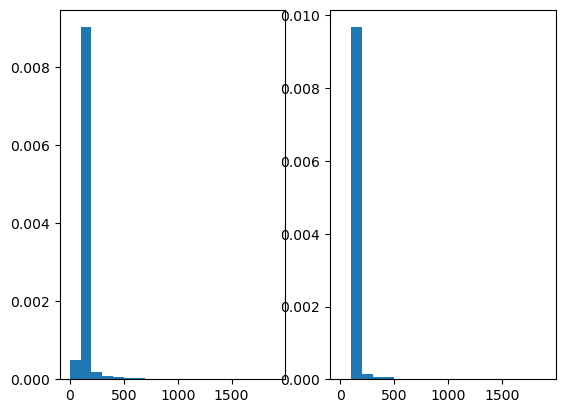

In [49]:
from matplotlib.ticker import PercentFormatter
f, axs = plt.subplots(1, 2)
axs[0].hist(bg_pixs,bins=np.arange(0,2000,100), density=True)
axs[1].hist(intensities,bins=np.arange(0,2000,100), density=True)

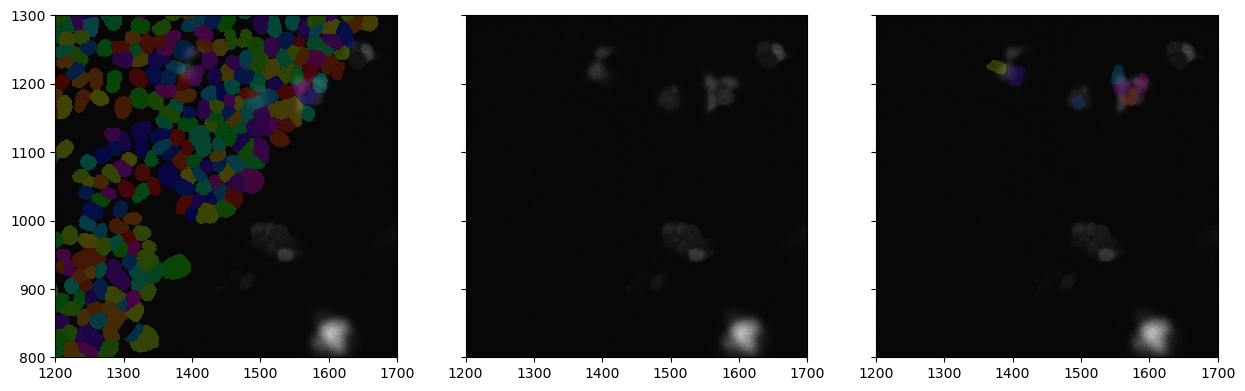

In [52]:
from matplotlib.colors import  to_hex,LinearSegmentedColormap
green_cmap = LinearSegmentedColormap.from_list('test',[[0,0,0],[1,1,1]],N=255)

vals = np.linspace(0,1,10000)
vlim=[0,4000]
x_start = 1200
y_start = 800
np.random.shuffle(vals)
cmap = plt.cm.gist_rainbow(vals)
cmap[0,:] = [0,0,0,0]
cmap = plt.cm.colors.ListedColormap(cmap)
        
f, axs = plt.subplots(1, 3,figsize=(15,20),sharex=True,sharey=True)
ax= axs[0]
ax.imshow(im,cmap=green_cmap,vmin=vlim[0],vmax=vlim[1],interpolation='none')
im_mask = np.ma.masked_array( masks, masks== 0)
#cmap = matplotlib.cm.jet.copy()
cmap.set_bad('black',0)
ax.imshow(im_mask, cmap=cmap, alpha=0.25,interpolation='none') 
ax.set_aspect('equal')

ax= axs[1]
ax.imshow(im,cmap=green_cmap,vmin=vlim[0],vmax=vlim[1],interpolation='none')

ax= axs[2]
ax.imshow(im,cmap=green_cmap,vmin=vlim[0],vmax=vlim[1],interpolation='none')
im_mask = np.ma.masked_array( sig_masks, sig_masks== 0)
#cmap = matplotlib.cm.jet.copy()
cmap.set_bad('black',0)
ax.imshow(im_mask, cmap=cmap, alpha=0.2,interpolation='none') 
ax.set_xlim(x_start,x_start+500)
ax.set_ylim(y_start,y_start+500)
ax.set_aspect('equal')

In [64]:
import nd2
import napari
from napari.utils import Colormap
with nd2.ND2File(nd2_loc) as ndfile:
    colormaps = []
    names = []
    for channel in ndfile.metadata.channels:
        name = channel.channel.name
        r = (channel.channel.colorRGB & 0xff)/255
        g = ((channel.channel.colorRGB & 0xff00) >> 8)/255
        b = ((channel.channel.colorRGB & 0xff0000) >> 16)/255
        a = 1
        colors = [[0,0,0,0],[r,g,b,a]]
        colormaps.append(Colormap(colors,name = name))
    xarr = ndfile.to_xarray(delayed=False)
    viewer = napari.view_image(xarr, channel_axis=1,colormap = colormaps,name=channel_names)